In [17]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'retina'

In [32]:
def errors(n, r=1):
    
    mesh = UnitSquareMesh(n, n)

    # start by solving for u using non-hybrid CG
    V = FunctionSpace(mesh, 'CG', r)
    bcs = [DirichletBC(V, Constant(0), DomainBoundary())]

    u = TrialFunction(V)
    v = TestFunction(V)
    a = inner(grad(u), grad(v))*dx
    f = Expression("2*pow(pi,2)*sin(pi*x[0])*sin(pi*x[1])", degree=r+3)
    L = f*v*dx

    u = Function(V)
    solve(a == L, u, bcs)

    neg_grad_u = project(-grad(u), VectorFunctionSpace(mesh, "DG", r-1))
    
    # post-process to get s(unconstrained)
    S_element = FiniteElement("BDM", mesh.ufl_cell(), r+3) 
    W = FunctionSpace(mesh, S_element)
    
    s = TrialFunction(W)
    t = TestFunction(W)
    w = Function(W)
    
    a = (inner(s, t) + inner(div(s), div(t)))*dx
    L = (f*div(t) + inner(neg_grad_u, t))*dx
    
    solve(a == L, w)
    s_alt = w
    
    # now post-process using constrained optimization
    S_element = FiniteElement('BDM', mesh.ufl_cell(), r+3)
    V_dg_element = FiniteElement('CG', mesh.ufl_cell(), r)
    W = FunctionSpace(mesh, S_element*V_dg_element)
    s, lam = TrialFunctions(W)
    t, v = TestFunctions(W)
    a = (inner(s, t) + inner(div(s), div(t)) + div(lam*t + s*v) + 1e-10*inner(lam,v))*dx
    L = (f*(div(t) + v) + inner(neg_grad_u, t + grad(v)))*dx

    w = Function(W)
    solve(a == L, w, bcs=[DirichletBC(W.sub(1), Constant(0), DomainBoundary())])
    s = w.sub(0)

    # finally, solve for sigma and u using regular Galerkin method
    # and compare to postprocessed solution. 
    U_space = FiniteElement("CG", mesh.ufl_cell(), r)
    S_space = FiniteElement('BDM', mesh.ufl_cell(), r+3)
    W = FunctionSpace(mesh, U_space*S_space)
    u_h,s_h = TrialFunctions(W)
    v_h,t_h = TestFunctions(W)
    sol = Function(W)
    a = (inner(s_h, t_h) - inner(grad(u_h), t_h) + inner(s_h, grad(v_h)))*dx
    L = (f*v_h)*dx
    solve(a == L, sol, bcs=[DirichletBC(W.sub(0), Constant(0), DomainBoundary())])
    s_g = sol.sub(1)

    # exact solutions
    u_exact = Expression("sin(pi*x[0])*sin(pi*x[1])", degree=r+3)
    s_exact = Expression(("-pi*cos(pi*x[0])*sin(pi*x[1])","-pi*sin(pi*x[0])*cos(pi*x[1])"), degree=r+5)

    u_error = errornorm(u_exact, u)
    grad_u_error = errornorm(s_exact, neg_grad_u)
    s_error = errornorm(s_exact, s)
    s_alt_error = errornorm(s_exact, s_alt)
    s_g_error = errornorm(s_exact, s_g)

    return u_error, grad_u_error, s_error, s_alt_error, s_g_error

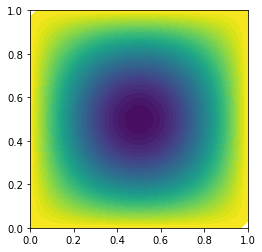

In [33]:
ns = [2**k for k in range(1,6)]
es = [errors(n, r=2) for n in ns]

Text(0, 0.5, 'error')

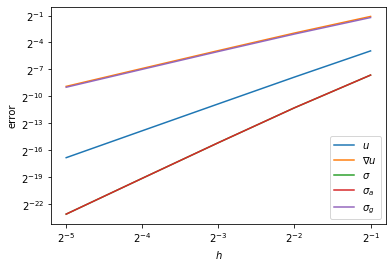

In [34]:
plt.loglog(1/np.array(ns), es, basex=2, basey=2)
plt.legend(['$u$',r'$\nabla u$',r'$\sigma$',r'$\sigma_a$', r'$\sigma_g$'])
plt.xlabel('$h$')
plt.ylabel('error')

In [35]:
rates = -np.diff(np.log2(es), axis=0)
rates

array([[2.91354294, 1.84846843, 3.64128737, 3.64128737, 1.83404609],
       [2.98123171, 1.95445108, 3.88428604, 3.88428609, 1.94361083],
       [2.99513983, 1.98754245, 3.96666266, 3.96666531, 1.98464703],
       [2.99863422, 1.99675481, 3.9895859 , 3.9891159 , 1.99671547]])